<a href="https://colab.research.google.com/github/palmaluisen/discrete-choice-model-predictions/blob/main/Modal_split_NN_and_RF_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desarrollo de modelos de Reparto modal 

## Cargar librerías

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
#from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Cargar y preparar datos

### Cargar df de costes y tiempos por modos

In [4]:
# Cargar dataframe df_ct con distancias, tiempos y costes de modos de transporte
df_ct=pd.read_excel("/content/gdrive/MyDrive/TFM/Script/Input data_modal split.xlsx", sheet_name='cost_time')
# Seleccionar columnas de la primera a la novena
df_ct=df_ct[df_ct.columns[0:9]]
# Cambiar nombre de columnas 'From' y 'To' a 'o' y 'd'
df_ct.rename(columns={"From":"o", "To":"d"}, inplace=True)
# Agregar columna 'o_d' de concatenación 'o_d'
df_ct["o_d"]=df_ct["o"].astype(str)+"_"+df_ct['d'].astype(str)
df_ct.iloc[:,2:]=df_ct.iloc[:,2:].round(2)
df_ct

,o,d,distance_km,Tiempo_CAR,Tiempo_BUS,Tiempo_BP,Coste_CAR,Coste_BUS,Coste_BP,o_d
0,1,1,0.00,14.38,18.46,5.00,2.50,1.00,0.00,1_1
1,1,2,101.97,77.77,136.73,334.36,27.99,16.30,1.02,1_2
2,1,3,14.51,19.54,32.72,51.85,6.13,3.18,0.15,1_3
3,1,4,16.37,24.47,38.35,57.86,6.59,3.46,0.16,1_4
4,1,5,40.09,36.79,62.46,134.48,12.52,7.01,0.40,1_5
...,...,...,...,...,...,...,...,...,...,...
14395,120,116,12.25,20.48,37.75,56.45,6.94,3.66,0.18,120_116
14396,120,117,10.95,24.11,30.14,50.96,6.47,3.38,0.16,120_117
14397,120,118,1.30,11.69,18.08,10.46,2.97,1.28,0.02,120_118
14398,120,119,7.20,19.47,23.48,35.22,5.11,2.57,0.10,120_119


### Cargar df de encuesta EPR

In [5]:
# Cargar dataframe data de datos de encuesta EPR
data=pd.read_excel("/content/gdrive/MyDrive/TFM/Script/Input data_modal split.xlsx", sheet_name='Datos_RM_Limpio (2)')
#Eliminar observaciones cuyo modo es "A_pie"
data=data[data["Modo_txt"]!="A_pie"]
data.reset_index(inplace=True)
data.drop(columns=["index"], inplace=True)
data

,ID_ENCUESTA,SEXO,EDAD,ESTUDIOS,Zona_Origen,Zona_Destino,Viaje_obligado,Motivo,Modo_txt,Orig_Dest_zona
0,26,MUJER,33,Estudios primarios acabados,1,4,No Obligado,HBO,Coche,1_4
1,27,MUJER,35,Estudios universitarios superiores acabados,1,15,No Obligado,HBO,Coche,1_15
2,28,MUJER,35,Estudios universitarios superiores acabados,1,15,No Obligado,HBO,Coche,1_15
3,29,HOMBRE,52,Formación profesional,1,19,Obligado,HBW,Coche,1_19
4,30,MUJER,69,Estudios universitarios superiores acabados,1,19,No Obligado,HBO,Coche,1_19
...,...,...,...,...,...,...,...,...,...,...
1582,2229,HOMBRE,57,Estudios primarios acabados,120,107,Obligado,HBW,Coche,120_107
1583,2230,MUJER,40,Estudios secundarios acabados,120,107,Obligado,HBW,Coche,120_107
1584,2232,HOMBRE,38,Estudios universitarios superiores acabados,120,111,Obligado,HBW,Coche,120_111
1585,2235,HOMBRE,57,Estudios universitarios superiores acabados,120,116,Obligado,HBW,Coche,120_116


In [6]:
# Ajuste de títulos: Sustituir espacios por _, cambiar texto de títulos a mayusculas
data.rename(lambda x: x.upper().strip().replace(' ',''), axis='columns', inplace=True)

In [7]:
# Agregar a cada fila los tiempos y costes de viajes de los modos
for i in range(data.shape[0]):
    data.loc[i, 'DIST_KM'] = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'distance_km'])
    data.loc[i, 'TIEMPO_CAR'] = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'Tiempo_CAR'])
    data.loc[i, 'COSTE_CAR']  = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'Coste_CAR'])
    data.loc[i, 'TIEMPO_BUS'] = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'Tiempo_BUS'])
    data.loc[i, 'COSTE_BUS']  = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'Coste_BUS'])
    data.loc[i, 'TIEMPO_BP'] = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'Tiempo_BP'])
    data.loc[i, 'COSTE_BP']  = float(df_ct.loc[df_ct['o_d']==data.loc[i, "ORIG_DEST_ZONA"], 'Coste_BP'])
data.head()

,ID_ENCUESTA,SEXO,EDAD,ESTUDIOS,ZONA_ORIGEN,ZONA_DESTINO,VIAJE_OBLIGADO,MOTIVO,MODO_TXT,ORIG_DEST_ZONA,DIST_KM,TIEMPO_CAR,COSTE_CAR,TIEMPO_BUS,COSTE_BUS,TIEMPO_BP,COSTE_BP
0,26,MUJER,33,Estudios primarios acabados,1,4,No Obligado,HBO,Coche,1_4,16.37,24.47,6.59,38.35,3.46,57.86,0.16
1,27,MUJER,35,Estudios universitarios superiores acabados,1,15,No Obligado,HBO,Coche,1_15,0.59,14.97,2.71,13.75,1.13,7.46,0.01
2,28,MUJER,35,Estudios universitarios superiores acabados,1,15,No Obligado,HBO,Coche,1_15,0.59,14.97,2.71,13.75,1.13,7.46,0.01
3,29,HOMBRE,52,Formación profesional,1,19,Obligado,HBW,Coche,1_19,2.27,13.51,3.32,15.82,1.49,14.51,0.03
4,30,MUJER,69,Estudios universitarios superiores acabados,1,19,No Obligado,HBO,Coche,1_19,2.27,13.51,3.32,15.82,1.49,14.51,0.03


## Exploración de los datos

In [8]:
data.columns

Index(['ID_ENCUESTA', 'SEXO', 'EDAD', 'ESTUDIOS', 'ZONA_ORIGEN',
       'ZONA_DESTINO', 'VIAJE_OBLIGADO', 'MOTIVO', 'MODO_TXT',
       'ORIG_DEST_ZONA', 'DIST_KM', 'TIEMPO_CAR', 'COSTE_CAR', 'TIEMPO_BUS',
       'COSTE_BUS', 'TIEMPO_BP', 'COSTE_BP'],
      dtype='object')

In [9]:
# Variables explicativas 
# Crear listas de las columnas según su tipo: continuas (cont) y categóricas (cat)
cont = ['EDAD', 'DIST_KM', 'TIEMPO_CAR', 'COSTE_CAR', 'TIEMPO_BUS', 'COSTE_BUS', 'TIEMPO_BP', 'COSTE_BP']
cat = ['SEXO','ESTUDIOS','VIAJE_OBLIGADO', 'MOTIVO', 'ORIG_DEST_ZONA']

# Variable dependiente
dep = 'MODO_TXT'

### Inspección de variable dependiente

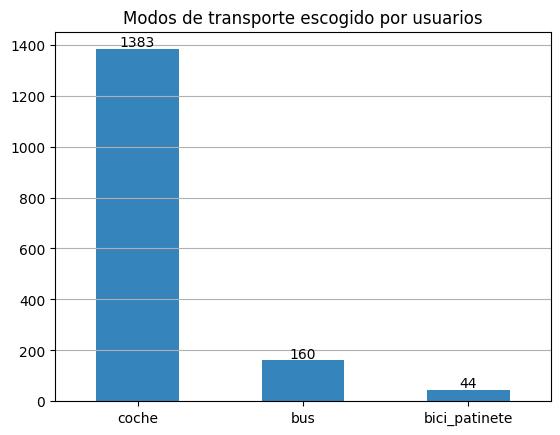

In [10]:
# Cambiar categorías a minúsculas
data[dep]=data[dep].map(lambda x: x.lower())

def add_value_label(x_list,y_list):
    for i in range(len(x_list)):
        plt.text(i,y_list[i]+10,y_list[i], ha="center")
val=data[dep].value_counts().to_list()
x_val=[0,1,2]

data[dep].value_counts().plot.bar(alpha=0.9)
plt.title('Modos de transporte escogido por usuarios')
plt.grid(axis='y')
plt.xticks(rotation=0)
add_value_label(x_val, val)
plt.show()

### Inspección de variables continuas

In [11]:
#Inspección de variables continuas
data[cont].describe().round(2)

,EDAD,DIST_KM,TIEMPO_CAR,COSTE_CAR,TIEMPO_BUS,COSTE_BUS,TIEMPO_BP,COSTE_BP
count,1587.00,1587.00,1587.00,1587.00,1587.00,1587.00,1587.00,1587.00
mean,42.88,6.46,17.33,4.50,24.36,2.20,29.20,0.08
std,12.63,7.91,5.48,2.03,10.36,1.22,25.91,0.08
min,16.00,0.00,10.03,2.50,10.06,1.00,5.00,0.00
25%,33.00,1.50,13.61,3.04,17.55,1.33,11.29,0.02
50%,43.00,4.13,16.13,4.00,22.25,1.90,22.35,0.06
75%,51.00,8.28,19.68,5.50,28.91,2.80,39.76,0.12
max,80.00,69.95,59.89,19.99,104.84,11.49,230.94,0.70


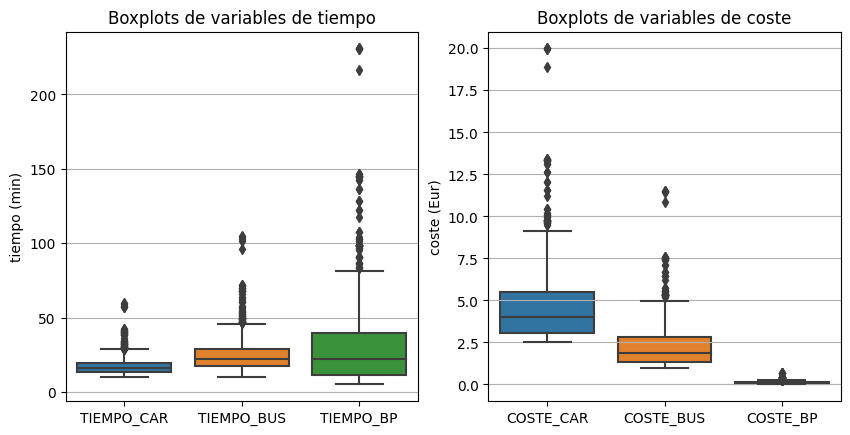

In [12]:
# Crear Boxplot de Tiempos y Costes
f = plt.figure(figsize=(10,4.8))
f.add_subplot(1,2,1)
sns.boxplot(x='variable', y='value', data=pd.melt(data[["TIEMPO_CAR",'TIEMPO_BUS','TIEMPO_BP']])).set(
            xlabel='', 
            ylabel='tiempo (min)')
plt.title("Boxplots de variables de tiempo")
plt.grid(axis='y')
f.add_subplot(1,2,2)
sns.boxplot(x='variable', y='value', data=pd.melt(data[['COSTE_CAR','COSTE_BUS','COSTE_BP']])).set(
            xlabel='', 
            ylabel='coste (Eur)')
plt.title("Boxplots de variables de coste")
plt.grid(axis='y')
plt.show()

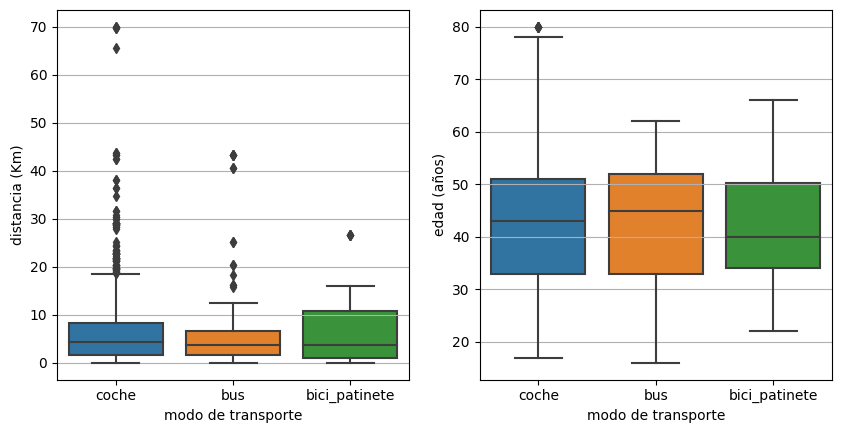

In [13]:
# Crear Boxplot de Distancias y Edades
f = plt.figure(figsize=(10,4.8))
f.add_subplot(1,2,1)
sns.boxplot(data=data, x="MODO_TXT", y="DIST_KM")
plt.xlabel('modo de transporte')
plt.ylabel('distancia (Km)')
plt.grid(axis='y')
f.add_subplot(1,2,2)
sns.boxplot(data=data, x="MODO_TXT", y="EDAD")
plt.xlabel('modo de transporte')
plt.ylabel('edad (años)')
plt.grid(axis='y')
plt.show()


### Inspección de variables categóricas

In [14]:
data[cat].astype('object').describe(include='all')

,SEXO,ESTUDIOS,VIAJE_OBLIGADO,MOTIVO,ORIG_DEST_ZONA
count,1587,1587,1587,1587,1587
unique,2,7,2,4,1031
top,HOMBRE,Estudios primarios acabados,Obligado,HBW,7_7
freq,945,455,808,731,19


In [15]:
# Variables categóricas iniciales
#cat = ['SEXO','ESTUDIOS','VIAJE_OBLIGADO', 'MOTIVO', 'ORIG_DEST_ZONA']

# Variables categóricas no se eliminaron
cat = ['SEXO','ESTUDIOS','VIAJE_OBLIGADO', 'MOTIVO']

#### Cambiar texto de categorías para reducir el tamaño

In [16]:
# Contar observaciones en cada categoría
# Cambiar nombres de categorías
data['SEXO'].replace({
    "HOMBRE" : "m",
    "MUJER" : "f",
    }, inplace=True)
data['SEXO'].value_counts()

m    945
f    642
Name: SEXO, dtype: int64

In [17]:
# Contar observaciones en cada categoría
# Cambiar nombres de categorías
data.ESTUDIOS = data.ESTUDIOS.astype("category")
data['ESTUDIOS'].replace({
    "Estudios primarios acabados" : "primaria_terminada",
    "Estudios secundarios acabados" : "secundaria_terminada",
    "Formación profesional" : "formacion_profesional",
    "Estudios universitarios superiores acabados" : "univers_terminada",
    "Estudios universitarios medios acabados" : "univers_terminada",
    "Sin estudios" : "sin_estudios",
    "Posgrado, Máster, Doctorado" : "posgrado"
    }, inplace=True)
data['ESTUDIOS']=pd.Categorical(data.ESTUDIOS, categories=['sin_estudios', 'primaria_terminada', 'secundaria_terminada', 'formacion_profesional', 'univers_terminada','posgrado'],
                                ordered=False)
data['ESTUDIOS'].value_counts()

primaria_terminada       455
secundaria_terminada     402
univers_terminada        336
formacion_profesional    315
sin_estudios              46
posgrado                  33
Name: ESTUDIOS, dtype: int64

In [18]:
# Cambiar nombres de categorías a minúsculas
# Contar observaciones por características
data['MOTIVO']=data['MOTIVO'].map(lambda x: x.lower())
data['MOTIVO'].value_counts()

hbw    731
hbo    649
nhb    189
hbs     18
Name: MOTIVO, dtype: int64

In [19]:
data['MOTIVO'].replace({
    'hbw'           :'hbws',
    'hbs'           :'hbws',
    'hbo'           :'hbo',
    'nhb'           :'nhb'
}, inplace=True)

data['MOTIVO'].value_counts()

hbws    749
hbo     649
nhb     189
Name: MOTIVO, dtype: int64

In [20]:
data['VIAJE_OBLIGADO'].replace({
    'Obligado'          :'si',
    'No Obligado'       :'no'
}, inplace=True)

data['VIAJE_OBLIGADO'].value_counts()

si    808
no    779
Name: VIAJE_OBLIGADO, dtype: int64

#### Gráficos de barras de variables categóricas

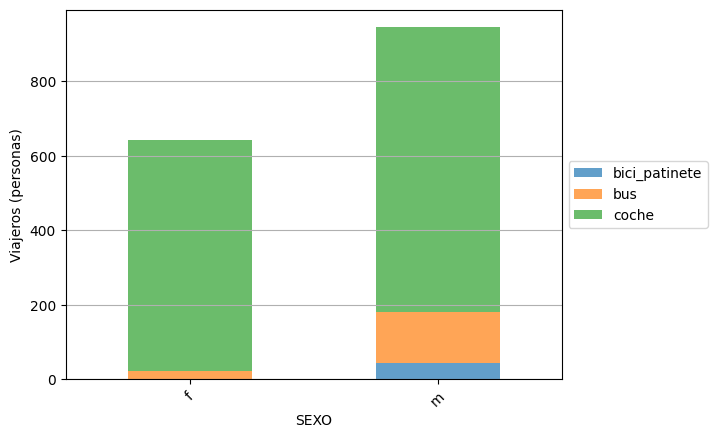

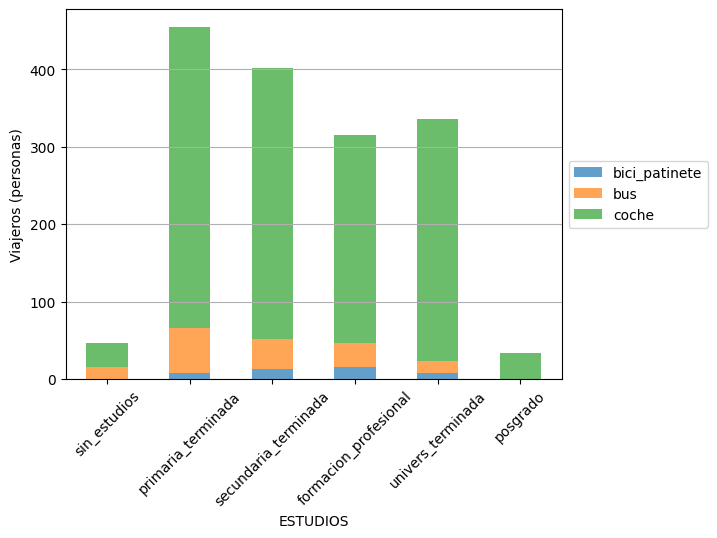

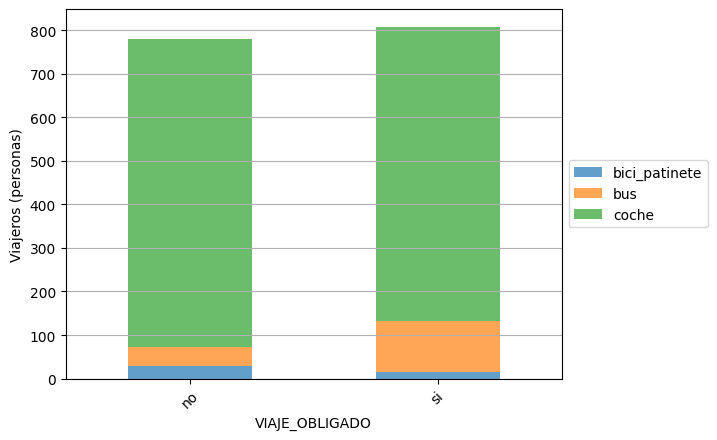

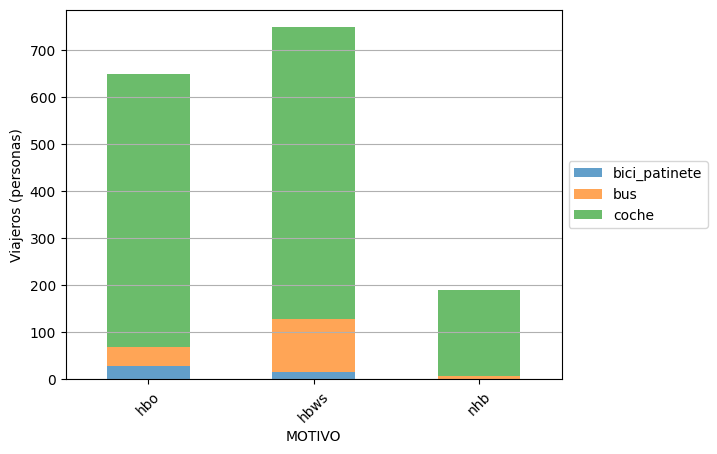

In [21]:
for col in cat:

    X_cat=data.groupby([col,'MODO_TXT']).size()
    X_cat=X_cat.reset_index()
    X_cat=pd.pivot_table(X_cat, columns='MODO_TXT', index=col, values=0)

    X_cat.plot(kind='bar', stacked=True, alpha=0.7);
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Viajeros (personas)')
    plt.xticks(rotation =45)

    plt.grid(axis='y')
    plt.show()

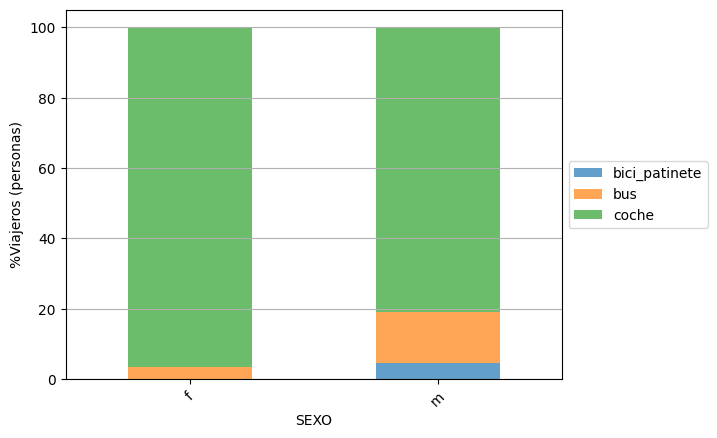

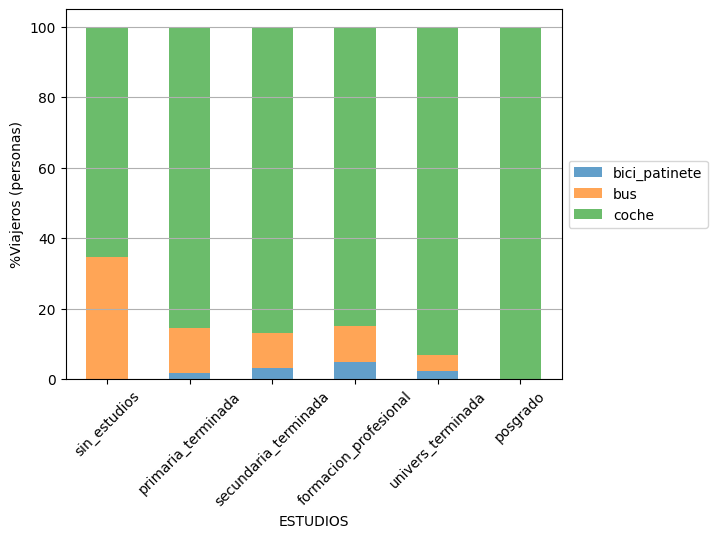

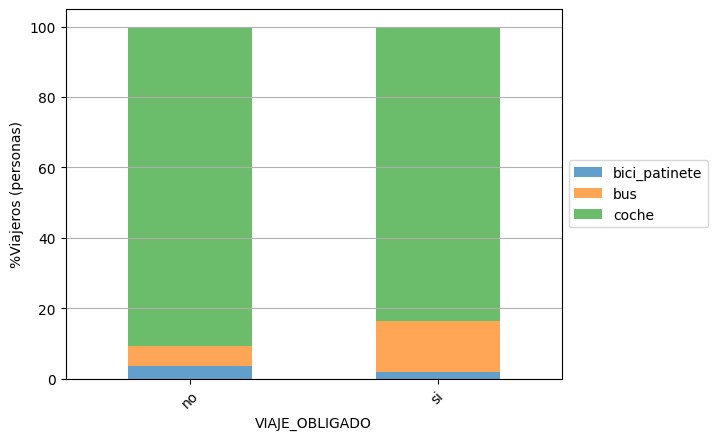

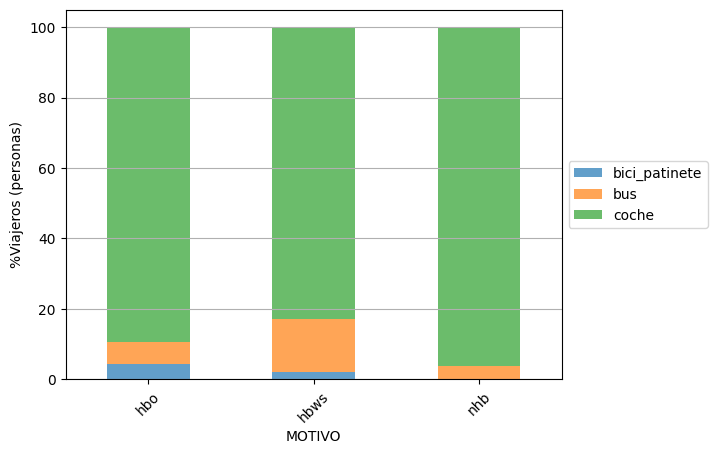

In [22]:
for col in cat:
  X_cat=data.groupby([col,'MODO_TXT']).size()
  X_cat=X_cat.reset_index()
  X_cat=pd.pivot_table(X_cat, columns='MODO_TXT', index=col, values=0)

  for i in range(X_cat.shape[0]):
    suma_filas = X_cat.sum(axis=1)
    X_cat = X_cat.div(suma_filas, axis=0)*100

  X_cat.plot(kind='bar', stacked=True, alpha=0.7);
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.ylabel('%Viajeros (personas)')
  plt.xticks(rotation =45)

  plt.grid(axis='y')
  plt.show()

In [23]:
col='SEXO'
X_cat=data.groupby([col,'MODO_TXT']).size()
X_cat=X_cat.reset_index()
X_cat=pd.pivot_table(X_cat, columns='MODO_TXT', index=col, values=0)

for i in range(len(X_cat.columns)):
  X_cat[X_cat.columns[i]] = X_cat[X_cat.columns[i]]/X_cat.sum(axis=1)

X_cat

MODO_TXT,bici_patinete,bus,coche
SEXO,,,
f,NaN,0.035826,0.999942
m,0.046561,0.152045,0.999740


In [24]:
X_cat.iloc[0,:]

MODO_TXT
bici_patinete         NaN
bus              0.035826
coche            0.999942
Name: f, dtype: float64

In [25]:
X_cat=data.groupby([cat[0],'MODO_TXT']).size()
X_cat=X_cat.reset_index()
X_cat=pd.pivot_table(X_cat, columns='MODO_TXT', index=cat[0], values=0)
X_cat

MODO_TXT,bici_patinete,bus,coche
SEXO,,,
f,NaN,23.0,619.0
m,44.0,137.0,764.0


In [26]:
100*X_cat.round(3)

MODO_TXT,bici_patinete,bus,coche
SEXO,,,
f,NaN,2300.0,61900.0
m,4400.0,13700.0,76400.0


## Crear df de variables explicativas y dependientes

In [27]:
# Convertir variables categóricas en variables dummy
df_var = pd.get_dummies(data[cat], drop_first=False)
# Eliminar variables dummie iniciales sexo_f,  ESTUDIOS_sin_estudios, VIAJE_OBLIGADO_no, MOTIVO_nhb
df_var.drop(["SEXO_f", "ESTUDIOS_sin_estudios", "VIAJE_OBLIGADO_no", "MOTIVO_nhb"], axis=1, inplace=True)
# Unir variables categóricas dummy y variables continuas
df_var = pd.concat([df_var, data[cont]], axis=1)
df_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   SEXO_m                          1587 non-null   uint8  
 1   ESTUDIOS_primaria_terminada     1587 non-null   uint8  
 2   ESTUDIOS_secundaria_terminada   1587 non-null   uint8  
 3   ESTUDIOS_formacion_profesional  1587 non-null   uint8  
 4   ESTUDIOS_univers_terminada      1587 non-null   uint8  
 5   ESTUDIOS_posgrado               1587 non-null   uint8  
 6   VIAJE_OBLIGADO_si               1587 non-null   uint8  
 7   MOTIVO_hbo                      1587 non-null   uint8  
 8   MOTIVO_hbws                     1587 non-null   uint8  
 9   EDAD                            1587 non-null   int64  
 10  DIST_KM                         1587 non-null   float64
 11  TIEMPO_CAR                      1587 non-null   float64
 12  COSTE_CAR                       15

In [28]:
# Cambiar nombres de categorías de variable dependiente:
"""
0: Coche
1: Bus
2: bici_patinete
"""
data[[dep]]=data[[dep]].replace({
    'coche':0,
    'bus':1,
    'bici_patinete':2,
})

# Agregar columna CHOICE de variables tanto explicativas como dependiente
df_var['CHOICE']=data[dep].copy()
#df_var[cat].head()

In [29]:
# Crear df_clean para preparar el df en modo wide (ancho)
df_clean=df_var[df_var['CHOICE'].isin([0,1,2])] #Solo incluye observaciones cuya decisión fue 0,1 ó 2.
#Forma del df
df_clean.shape

(1587, 18)

### Dividir los datos en entrenamiento y prueba 
Con un 30% de prueba

In [30]:
# Split data in train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(columns=['CHOICE']),
                                                 df_clean.CHOICE,
                                                 stratify=df_clean.CHOICE,
                                                 test_size=0.3, random_state=42)

df_clean_train = X_train.copy()
df_clean_train['CHOICE'] = y_train
df_clean_test = X_test.copy()
df_clean_test ['CHOICE'] = y_test

print("df_clean_train", df_clean_train.shape)
print("df_clean_test", df_clean_test.shape)

df_clean_train (1110, 18)
df_clean_test (477, 18)


In [31]:
df_clean_train.to_excel('/content/gdrive/MyDrive/TFM/Script/df_clean_train.xlsx')
df_clean_test.to_excel('/content/gdrive/MyDrive/TFM/Script/df_clean_test.xlsx')

## Balancear las clases
https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/
Para lidiar con el problema de clases desbalanceadas existen distintas estrategias entre las cuales están: 
+ Copiar las clases desbalanceadas para balancear las clases, pero con esta técnica se corre el riesgo de sobreajuste.

+ Subsampling: eliminar observaciones de la clase mayoritaria, esta opción no es viable por la poca cantidad de muestras que se tiene. 

+ Oversampling: Crear nuevas observaciones "sintéticas" de la clase minoritaria usando la función RandomOverSampler

+ Estratetegia Resampling con Smote-Tomek

In [32]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

In [33]:
X=df_clean_train[df_clean_train['CHOICE'].isin([0,1,2])]
y=np.ravel(df_clean_train[df_clean_train['CHOICE'].isin([0,1,2])][['CHOICE']].astype(int))
ros = RandomOverSampler(random_state=123)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [34]:
print ("Distribution before resampling {}".format(Counter(y)))
print ("Distribution after resampling {}".format(Counter(y_resampled)))

Distribution before resampling Counter({0: 967, 1: 112, 2: 31})
Distribution after resampling Counter({0: 967, 1: 967, 2: 967})


In [35]:
bal_data_train = X_resampled.copy()
bal_data_train['CHOICE'] = list(y_resampled)

bal_data_train=bal_data_train.sample(frac=1).reset_index(drop=True)

In [36]:
# cat_dummy=['SEXO_m', 'ESTUDIOS_primaria_terminada', 'ESTUDIOS_secundaria_terminada', 'ESTUDIOS_formacion_profesional',
#        'ESTUDIOS_univers_terminada', 'ESTUDIOS_posgrado', 'VIAJE_OBLIGADO_si', 'MOTIVO_hbo', 'MOTIVO_hbws']
# for col in cat_dummy:
#     sns.countplot(data=bal_data_train, x=col, hue="CHOICE")
#     plt.grid(axis='y')
#     #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()

[0.83540379 0.15348016]
[1172.82879067  502.70420753]


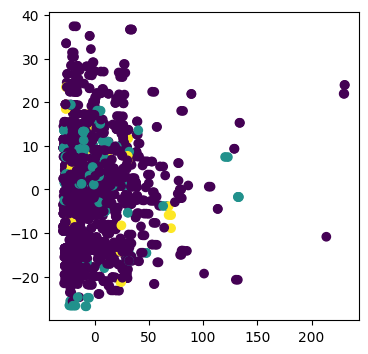

In [37]:
# PCA 
import numpy as np
from sklearn.decomposition import PCA
X = df_clean.drop(columns=['CHOICE'])
pca = PCA(n_components=2)
pca.fit(X)
df_clean_reduced = pca.transform(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)
df_clean_reduced=pd.DataFrame({"PC1": [fila[0] for fila in df_clean_reduced],
             "PC2": [fila[1] for fila in df_clean_reduced]})

plt.figure(figsize=(4,4))
plt.scatter(df_clean_reduced.PC1, df_clean_reduced.PC2, c=df_clean.CHOICE)

In [38]:
df_clean_reduced=pd.DataFrame({"PC1": [fila[0] for fila in df_clean_reduced],
             "PC2": [fila[1] for fila in df_clean_reduced]})

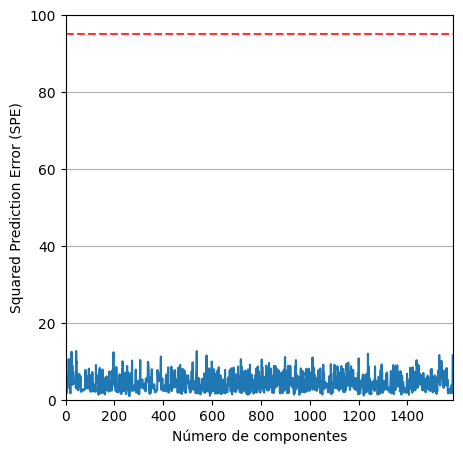

In [39]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Generamos datos de ejemplo
X = df_clean.drop(columns=['CHOICE'])

# Creamos un objeto PCA y ajustamos el modelo a los datos
pca = PCA(n_components=3)
pca.fit(X)

# Calculamos el SPE para cada observación
spe = np.sum((X - pca.inverse_transform(pca.transform(X)))**2, axis=1)

# Creamos el gráfico SPE vs número de componentes
plt.figure(figsize=[5,5])
plt.plot(range(len(spe)), spe)
plt.plot([0,1600],[95,95], c='red', linestyle='dashed', alpha=0.8)
plt.xlabel('Número de componentes')
plt.ylim([0,100])
plt.xlim([0,df_clean.shape[0]])
plt.ylabel('Squared Prediction Error (SPE)')
plt.grid(axis='y')
plt.show()

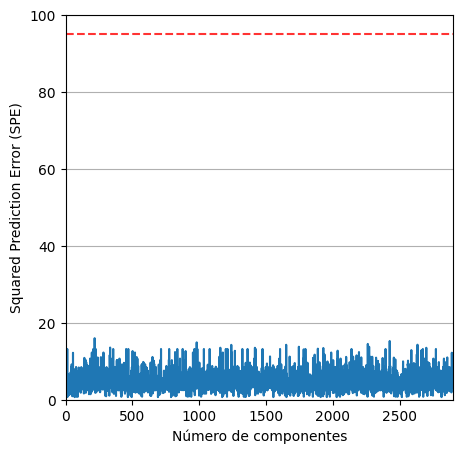

In [40]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Generamos datos de ejemplo
X = bal_data_train #.drop(columns=['CHOICE', "CAR", 'BUS','BP'])

# Creamos un objeto PCA y ajustamos el modelo a los datos
pca = PCA(n_components=3)
pca.fit(X)

# Calculamos el SPE para cada observación
spe = np.sum((X - pca.inverse_transform(pca.transform(X)))**2, axis=1)

# Creamos el gráfico SPE vs número de componentes
plt.figure(figsize=[5,5])
plt.plot(range(len(spe)), spe)
plt.plot([0,bal_data_train.shape[0]],[95,95], c='red', linestyle='dashed', alpha=0.8)
plt.xlabel('Número de componentes')
plt.ylim([0,100])
plt.xlim([0,bal_data_train.shape[0]])
plt.ylabel('Squared Prediction Error (SPE)')
plt.grid(axis='y')
plt.show()

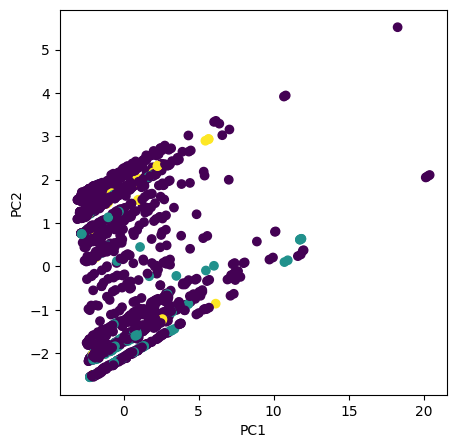

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = df_clean.drop(columns=['CHOICE'])
y = df_clean.CHOICE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=[5,5])
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


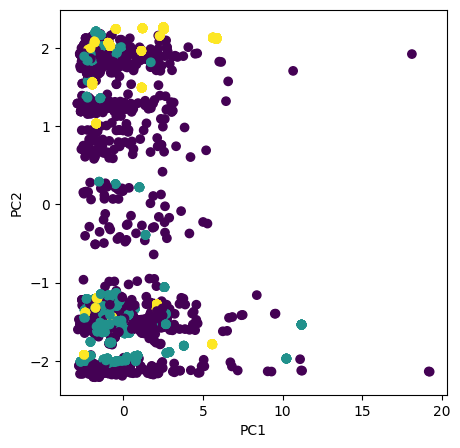

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = bal_data_train #.drop(columns=['CHOICE', "CAR", 'BUS','BP'])
y = bal_data_train.CHOICE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=[5,5])
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


[0.84713089 0.14195592]
[1660.98435362  679.93443246]


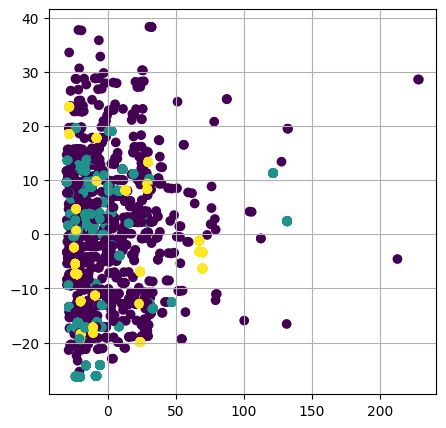

In [43]:
X = bal_data_train #.drop(columns=['CHOICE', "CAR", 'BUS','BP'])
pca = PCA(n_components=2)
pca.fit(X)
df_clean_reduced = pca.transform(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)
df_clean_reduced=pd.DataFrame({"PC1": [fila[0] for fila in df_clean_reduced],
             "PC2": [fila[1] for fila in df_clean_reduced]})

plt.figure(figsize=(5,5))
plt.scatter(df_clean_reduced.PC1, df_clean_reduced.PC2, c=bal_data_train.CHOICE)
plt.grid()

In [44]:
# Crear unos nuevos custom_id crecientes y continuos tanto para test como para train
# bal_data_train[obs_id_column] = np.arange(bal_data_train.shape[0], dtype=int) + 1
# bal_data_train.to_excel('/content/gdrive/MyDrive/TFM/Script/df_balanced.xlsx')

## Tratamiento de datos para el uso de Redes Neuronales 

In [45]:
# Crear conjuntos de datos X e y train y test

y_train = np.array(bal_data_train["CHOICE"], dtype=np.uint8) 
y_test = np.array(df_clean_test["CHOICE"], dtype=np.uint8) 

X_train = bal_data_train[bal_data_train.columns[0:17]]
X_test = df_clean_test[bal_data_train.columns[0:17]]

# Normalizar las columnas numéricas
for col in cont:
    mean = X_train[col].mean()
    sd = X_train[col].std()
    X_train[col]=(X_train[col]-mean)/sd
    X_test[col]=(X_test[col]-mean)/sd

X_train = X_train.values
X_test = X_test.values

<ipython-input-45-2e4e21cba2ea>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col]=(X_train[col]-mean)/sd
<ipython-input-45-2e4e21cba2ea>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col]=(X_test[col]-mean)/sd


In [46]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2901, 17) (477, 17)
(2901,) (477,)


### Creación del modelo de Redes Neuronales

In [47]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [48]:
# Limpiar backend 
keras.backend.clear_session()

# Hiperparámetros
n_epoch=6500
lr=0.001
batch_size=128
optimizer=tf.keras.optimizers.Adam(learning_rate=lr)

# Crear modelo de red neuronal
model_NN = tf.keras.models.Sequential()
model_NN.add(Dense(units=192, activation='relu', input_shape=(X_train.shape[1],),
                kernel_regularizer=regularizers.l2(0.1),
                activity_regularizer=regularizers.l1(0.01)))
model_NN.add(tf.keras.layers.Dropout(0.1))
model_NN.add(Dense(128, activation='relu'))
model_NN.add(tf.keras.layers.Dropout(0.1))
model_NN.add(Dense(64, activation='relu'))
model_NN.add(tf.keras.layers.Dropout(0.1))
#model.add(Dense(64, activation='relu'))
model_NN.add(Dense(32, activation='relu'))
model_NN.add(tf.keras.layers.Dropout(0.1))
model_NN.add(Dense(16, activation='relu'))
model_NN.add(tf.keras.layers.Dropout(0.1))
model_NN.add(Dense(3, activation='softmax'))

# visualizar arquitectura del modelo y dimensiones
model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               3456      
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               24704     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

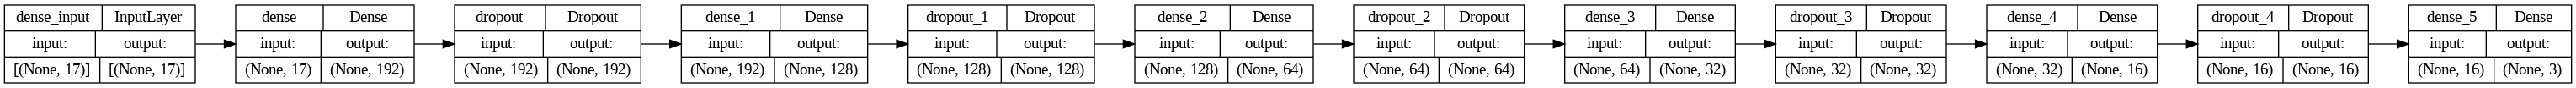

In [49]:
from keras.utils import plot_model
plot_model(model_NN, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="LR")

In [50]:
checkpoint_filepath = 'best_weights.hdf5'

# earlyStop = EarlyStopping(monitor='val_accuracy', patience=500, 
#                          verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_weights_only=False, 
                                      monitor='val_accuracy',
                                      mode='max', 
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3, 
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)

callbacks = [checkpoint, learningrate]
#callbacks = [earlyStop, checkpoint, learningrate]

In [51]:
# Compilar el modelo
model_NN.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

hist =  model_NN.fit(X_train, 
                  y_train,
                  batch_size=batch_size,
                  
                  epochs=n_epoch,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=(X_test, y_test))

Se han truncado las últimas 5000 líneas del flujo de salida.
23/23 [==============================] - 0s 6ms/step - loss: 0.0929 - accuracy: 0.9828 - val_loss: 0.7909 - val_accuracy: 0.8742 - lr: 1.0000e-05
Epoch 4002/6500
23/23 [==============================] - 0s 6ms/step - loss: 0.0909 - accuracy: 0.9841 - val_loss: 0.7918 - val_accuracy: 0.8700 - lr: 1.0000e-05
Epoch 4003/6500
23/23 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.9859 - val_loss: 0.7963 - val_accuracy: 0.8679 - lr: 1.0000e-05
Epoch 4004/6500
23/23 [==============================] - 0s 6ms/step - loss: 0.0869 - accuracy: 0.9852 - val_loss: 0.8079 - val_accuracy: 0.8616 - lr: 1.0000e-05
Epoch 4005/6500
23/23 [==============================] - 0s 6ms/step - loss: 0.0819 - accuracy: 0.9883 - val_loss: 0.8062 - val_accuracy: 0.8616 - lr: 1.0000e-05
Epoch 4006/6500
23/23 [==============================] - 0s 6ms/step - loss: 0.0882 - accuracy: 0.9831 - val_loss: 0.8071 - val_accuracy: 0.8637 

4/4 [==============================] - 0s 4ms/step - loss: 0.9192 - accuracy: 0.8910
Error (test):0.91922926902771
Accuracy (Test): 0.8909853100776672


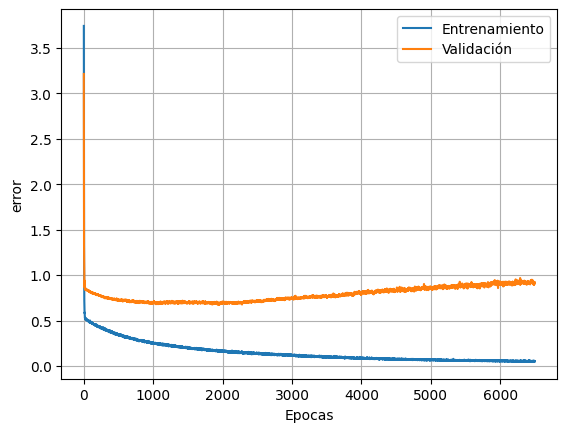

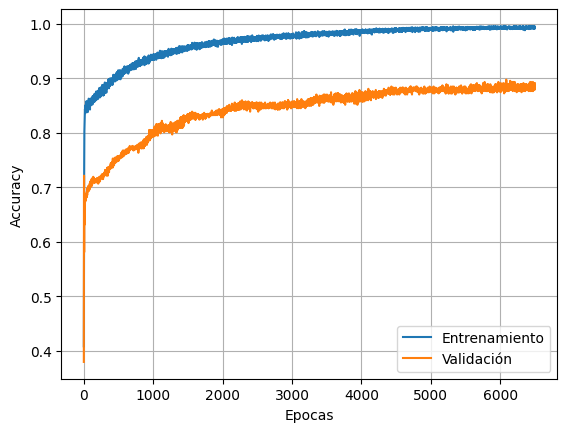

In [52]:
def plot_curves(history):
    plt.figure()
    plt.xlabel('Epocas')
    plt.ylabel('error')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid()
    plt.legend(['Entrenamiento', 'Validación'])

    plt.figure()
    plt.xlabel('Epocas')
    plt.ylabel('Accuracy')
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.grid()
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right');

plot_curves(hist.history)
results = model_NN.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Error (test):{results[0]}\nAccuracy (Test): {results[1]}')

15/15 [==============================] - 0s 1ms/step


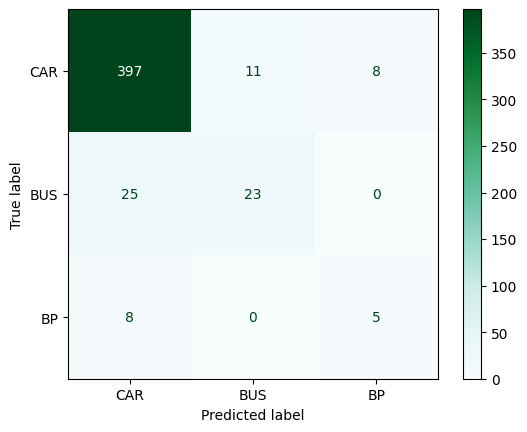

In [53]:
# Matriz de confusión de Red Neuronal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_proba = model_NN.predict(X_test)

y_true = [i for i in df_clean_test.CHOICE]
y_pred = [np.argmax([y_proba[i][0], y_proba[i][1], y_proba[i][2]]) for i in range(len(y_proba))]
target_names = ['CAR','BUS', "BP"]
cm = confusion_matrix(y_true, y_pred, labels= [0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names) 
disp.plot(cmap=plt.cm.BuGn)
plt.show()  

In [54]:
# Reporte de clasificación de Red Neuornal
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 

target_names = ['CAR','BUS', "BP"]
print(classification_report(y_true, y_pred, target_names=target_names)) #

              precision    recall  f1-score   support

         CAR       0.92      0.95      0.94       416
         BUS       0.68      0.48      0.56        48
          BP       0.38      0.38      0.38        13

    accuracy                           0.89       477
   macro avg       0.66      0.61      0.63       477
weighted avg       0.88      0.89      0.89       477



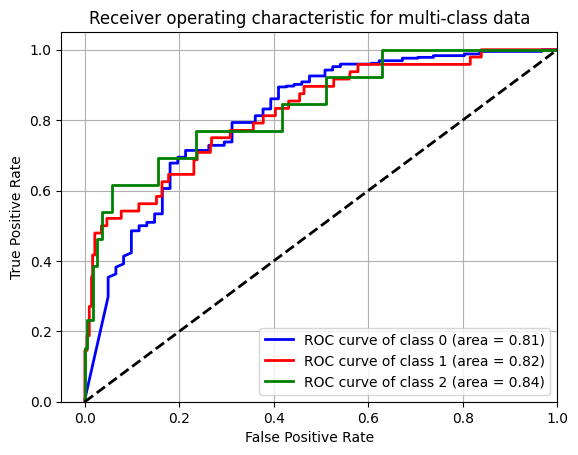

In [55]:
# Curva ROC Multiclase de Red Neuronal
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from itertools import cycle
from sklearn.metrics import roc_curve, auc

y_true=pd.get_dummies(df_clean_test.CHOICE).values
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], [y_proba[idx][i] for idx in range(len(y_proba))])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.grid()
plt.show()

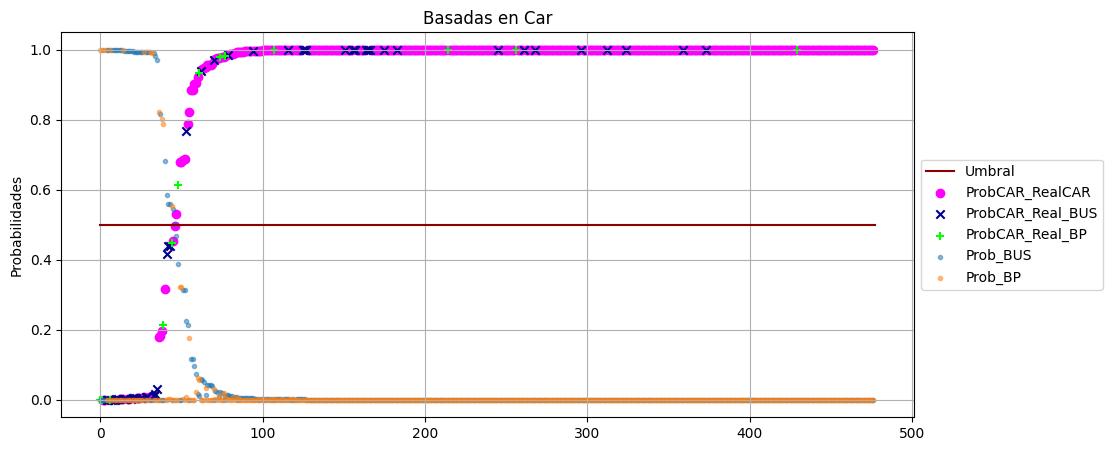

In [56]:
y_score = y_proba.copy()
umbral=0.5
df_comparativo = pd.DataFrame({"Obs": df_clean_test.CHOICE, "Pred_CAR": y_score[:,0], "Pred_BUS": y_score[:,1], "Pred_BP": y_score[:,2]})
df_comparativo.sort_values("Pred_CAR", ascending = True, inplace = True)
scatter_x = np.array(range(len(y_score)))
scatter_y = np.array(df_comparativo.Pred_CAR)
group = np.array(df_comparativo.Obs)
cdict = {0: "magenta", 1: "darkblue", 2: "#00ff00"}
tdict = {0: "o", 1: "x", 2: "+"}
names =["ProbCAR_RealCAR", "ProbCAR_Real_BUS", "ProbCAR_Real_BP"]

fig, ax = plt.subplots(figsize=(11,5))
plt.grid()
plt.title("Basadas en Car")
plt.ylabel("Probabilidades")
plt.plot([0,df_comparativo.shape[0]],[umbral,umbral],color="darkred", label="Umbral")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker=tdict[g], label = names[g])
ax.legend()
plt.scatter(range(len(y_score)), df_comparativo.Pred_BUS, label="Prob_BUS", marker=".", alpha=0.5)
plt.scatter(range(len(y_score)), df_comparativo.Pred_BP, label="Prob_BP", marker=".", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

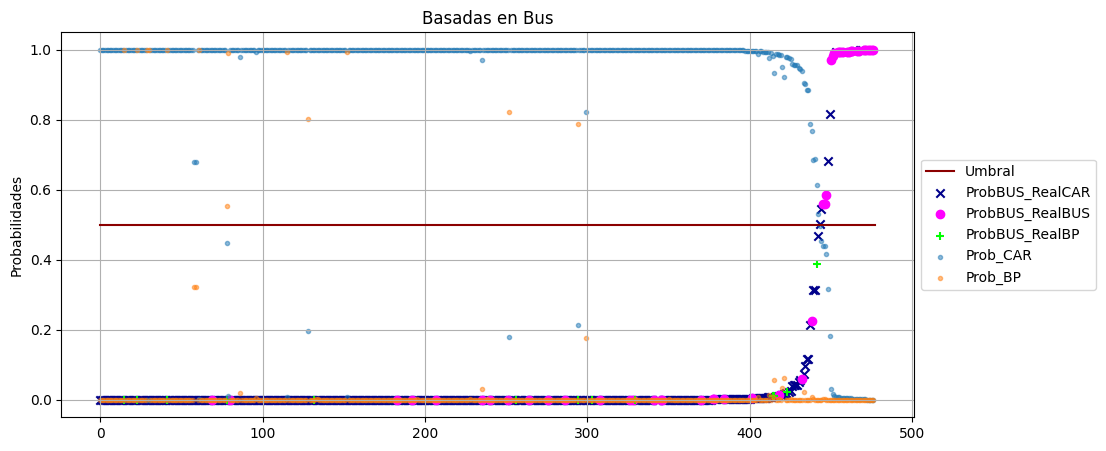

In [57]:
umbral=0.5
df_comparativo = pd.DataFrame({"Obs": df_clean_test.CHOICE, "Pred_CAR": y_score[:,0], "Pred_BUS": y_score[:,1], "Pred_BP": y_score[:,2]})
df_comparativo.sort_values("Pred_BUS", ascending = True, inplace = True)
scatter_x = np.array(range(len(y_score)))
scatter_y = np.array(df_comparativo.Pred_BUS)
group = np.array(df_comparativo.Obs)
cdict = {0: "darkblue", 1: "magenta", 2: "#00ff00"}
tdict = {0: "x", 1: "o", 2: "+"}
names =["ProbBUS_RealCAR", "ProbBUS_RealBUS", "ProbBUS_RealBP"]

fig, ax = plt.subplots(figsize=(11,5))
plt.grid()
plt.title("Basadas en Bus")
plt.ylabel("Probabilidades")
plt.plot([0,df_comparativo.shape[0]],[umbral,umbral],color="darkred", label="Umbral")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker=tdict[g], label = names[g])
ax.legend()
plt.scatter(range(len(y_score)), df_comparativo.Pred_CAR, label="Prob_CAR", marker=".", alpha=0.5)
plt.scatter(range(len(y_score)), df_comparativo.Pred_BP, label="Prob_BP", marker=".", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

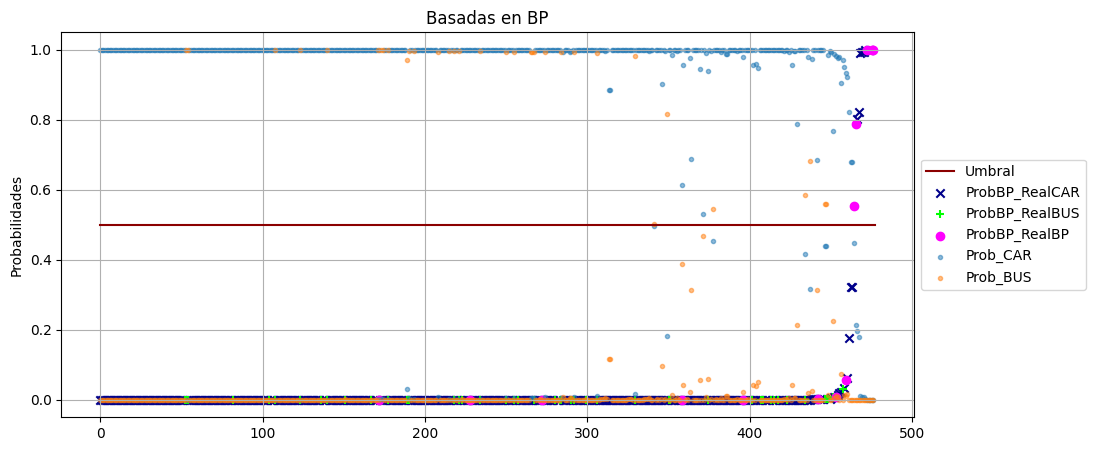

In [58]:
umbral=0.5
df_comparativo = pd.DataFrame({"Obs": df_clean_test.CHOICE, "Pred_CAR": y_score[:,0], "Pred_BUS": y_score[:,1], "Pred_BP": y_score[:,2]})
df_comparativo.sort_values("Pred_BP", ascending = True, inplace = True)
scatter_x = np.array(range(len(y_score)))
scatter_y = np.array(df_comparativo.Pred_BP)
group = np.array(df_comparativo.Obs)
cdict = {0: "darkblue", 1: "#00ff00", 2: "magenta"}
tdict = {0: "x", 1: "+", 2: "o"}
names =["ProbBP_RealCAR", "ProbBP_RealBUS", "ProbBP_RealBP"]

fig, ax = plt.subplots(figsize=(11,5))
plt.grid()
plt.title("Basadas en BP")
plt.ylabel("Probabilidades")
plt.plot([0,df_comparativo.shape[0]],[umbral,umbral],color="darkred", label="Umbral")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker=tdict[g], label = names[g])
ax.legend()
plt.scatter(range(len(y_score)), df_comparativo.Pred_CAR, label="Prob_CAR", marker=".", alpha=0.5)
plt.scatter(range(len(y_score)), df_comparativo.Pred_BUS, label="Prob_BUS", marker=".", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Random Forest

In [59]:
# Preprocesado y modelado
# ==============================================================================
#from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing


In [60]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [50,100,150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Bucle para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo_RF = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo_RF.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo_RF.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {

In [61]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head()

,oob_accuracy,criterion,max_depth,max_features,n_estimators
0,0.991727,gini,NaN,5,50
27,0.991382,gini,20.0,5,50
65,0.990348,entropy,20.0,5,150
64,0.990348,entropy,20.0,5,100
38,0.990348,entropy,NaN,5,150


In [62]:
# Entrenar manualmente el mejor modelo RF
modelo_RF = RandomForestClassifier(
    oob_score    = True,
    n_jobs       = -1,
    random_state = 123,
    n_estimators=150,
    max_depth=None,
    max_features=9,
    criterion="entropy"   
    )
modelo_RF.fit(X_train, y_train)

# Accuracy del modelo en Train y Test

# Train 
predicciones = modelo_RF.predict(X = X_train)
accuracy_RF_train = accuracy_score(
    y_true    = y_train,
    y_pred    = predicciones,
    normalize = True)
# Test 
predicciones = modelo_RF.predict(X = X_test)
accuracy_RF_test = accuracy_score(
    y_true    = y_test,
    y_pred    = predicciones,
    normalize = True)

print("Train Accuracy", accuracy_RF_train)
print("Test Accuracy", accuracy_RF_test)

Train Accuracy 0.9979317476732161
Test Accuracy 0.939203354297694


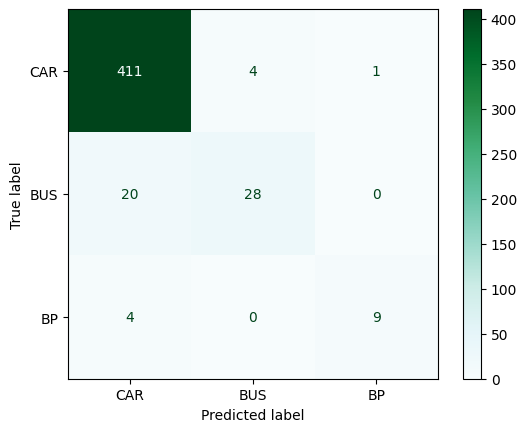

In [63]:
# Matriz de confusión de Random Forest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = modelo_RF.predict(X_test)

y_true = [i for i in df_clean_test.CHOICE]
#y_pred = [np.argmax([y_proba[i][0], y_proba[i][1], y_proba[i][2]]) for i in range(len(y_proba))]
target_names = ['CAR','BUS', "BP"]
cm = confusion_matrix(y_true, y_pred, labels= [0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names) 
disp.plot(cmap=plt.cm.BuGn)
plt.show()  

In [64]:
# Reporte de clasificación de Random Forest
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 

target_names = ['CAR','BUS', "BP"]
print(classification_report(y_true, y_pred, target_names=target_names)) #

              precision    recall  f1-score   support

         CAR       0.94      0.99      0.97       416
         BUS       0.88      0.58      0.70        48
          BP       0.90      0.69      0.78        13

    accuracy                           0.94       477
   macro avg       0.91      0.75      0.82       477
weighted avg       0.94      0.94      0.93       477



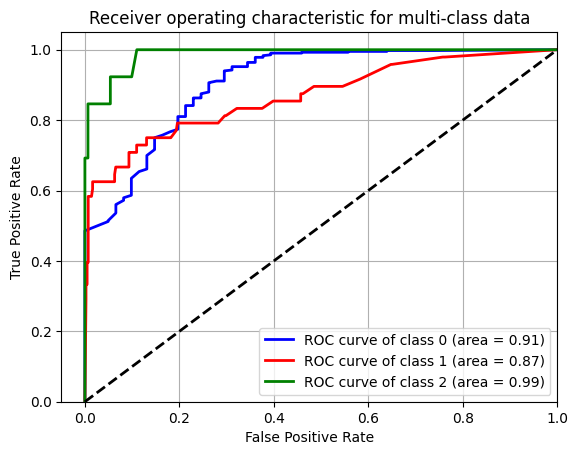

In [65]:
# Curva ROC Multiclase de Random Forest
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from itertools import cycle
from sklearn.metrics import roc_curve, auc

y_proba=modelo_RF.predict_proba(X_test)

y_true=pd.get_dummies(df_clean_test.CHOICE).values
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], [y_proba[idx][i] for idx in range(len(y_proba))])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [66]:
y_score = y_proba.copy()

In [67]:
y_score

array([[0.94      , 0.03333333, 0.02666667],
       [0.96666667, 0.03333333, 0.        ],
       [0.99333333, 0.00666667, 0.        ],
       ...,
       [0.95333333, 0.04666667, 0.        ],
       [0.95333333, 0.02666667, 0.02      ],
       [0.96      , 0.02666667, 0.01333333]])

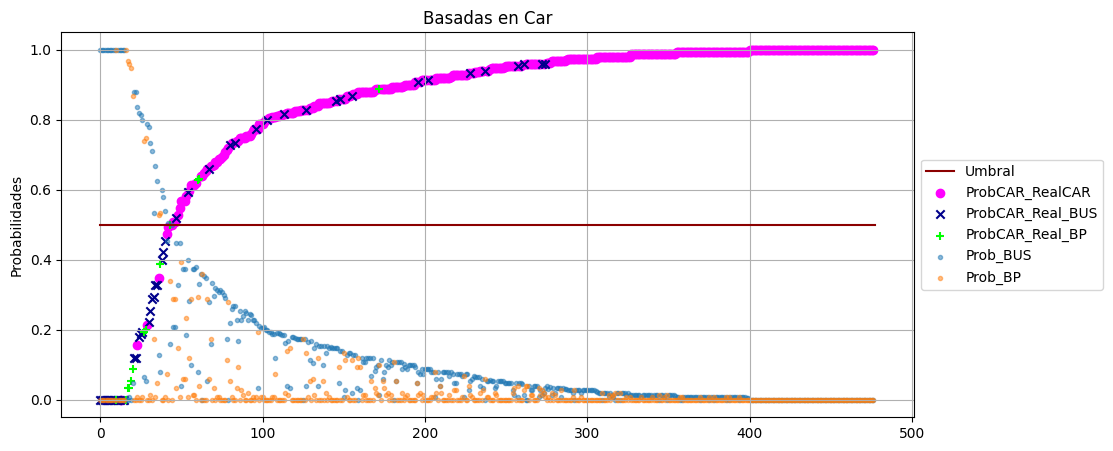

In [68]:
umbral=0.5
df_comparativo = pd.DataFrame({"Obs": df_clean_test.CHOICE, "Pred_CAR": y_score[:,0], "Pred_BUS": y_score[:,1], "Pred_BP": y_score[:,2]})
df_comparativo.sort_values("Pred_CAR", ascending = True, inplace = True)
scatter_x = np.array(range(len(y_score)))
scatter_y = np.array(df_comparativo.Pred_CAR)
group = np.array(df_comparativo.Obs)
cdict = {0: "magenta", 1: "darkblue", 2: "#00ff00"}
tdict = {0: "o", 1: "x", 2: "+"}
names =["ProbCAR_RealCAR", "ProbCAR_Real_BUS", "ProbCAR_Real_BP"]

fig, ax = plt.subplots(figsize=(11,5))
plt.grid()
plt.title("Basadas en Car")
plt.ylabel("Probabilidades")
plt.plot([0,df_comparativo.shape[0]],[umbral,umbral],color="darkred", label="Umbral")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker=tdict[g], label = names[g])
ax.legend()
plt.scatter(range(len(y_score)), df_comparativo.Pred_BUS, label="Prob_BUS", marker=".", alpha=0.5)
plt.scatter(range(len(y_score)), df_comparativo.Pred_BP, label="Prob_BP", marker=".", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [69]:
df_comparativo

,Obs,Pred_CAR,Pred_BUS,Pred_BP
931,1,0.0,1.0,0.0
1159,1,0.0,1.0,0.0
846,1,0.0,1.0,0.0
222,1,0.0,1.0,0.0
227,1,0.0,1.0,0.0
...,...,...,...,...
895,0,1.0,0.0,0.0
883,0,1.0,0.0,0.0
998,0,1.0,0.0,0.0
1547,0,1.0,0.0,0.0


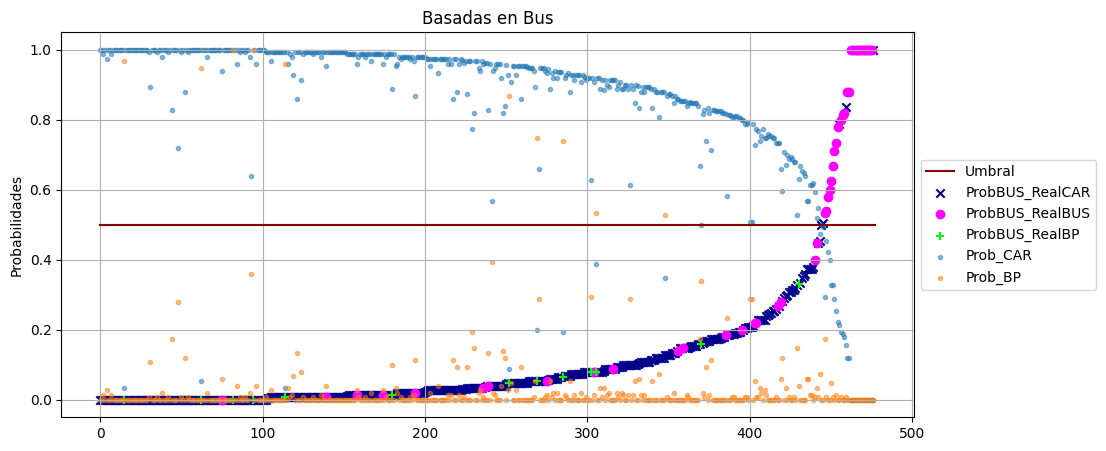

In [70]:
umbral=0.5
df_comparativo = pd.DataFrame({"Obs": df_clean_test.CHOICE, "Pred_CAR": y_score[:,0], "Pred_BUS": y_score[:,1], "Pred_BP": y_score[:,2]})
df_comparativo.sort_values("Pred_BUS", ascending = True, inplace = True)
scatter_x = np.array(range(len(y_score)))
scatter_y = np.array(df_comparativo.Pred_BUS)
group = np.array(df_comparativo.Obs)
cdict = {0: "darkblue", 1: "magenta", 2: "#00ff00"}
tdict = {0: "x", 1: "o", 2: "+"}
names =["ProbBUS_RealCAR", "ProbBUS_RealBUS", "ProbBUS_RealBP"]

fig, ax = plt.subplots(figsize=(11,5))
plt.grid()
plt.title("Basadas en Bus")
plt.ylabel("Probabilidades")
plt.plot([0,df_comparativo.shape[0]],[umbral,umbral],color="darkred", label="Umbral")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker=tdict[g], label = names[g])
ax.legend()
plt.scatter(range(len(y_score)), df_comparativo.Pred_CAR, label="Prob_CAR", marker=".", alpha=0.5)
plt.scatter(range(len(y_score)), df_comparativo.Pred_BP, label="Prob_BP", marker=".", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

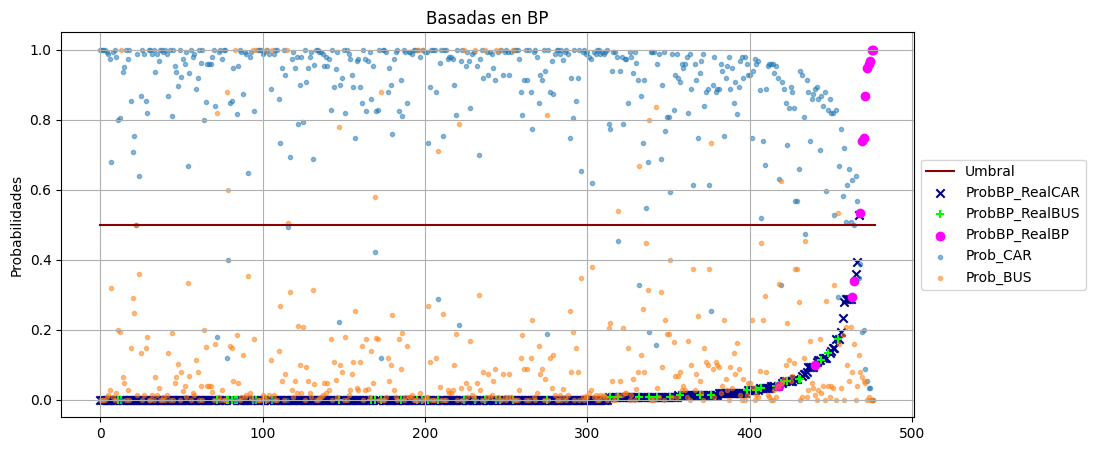

In [71]:
umbral=0.5
df_comparativo = pd.DataFrame({"Obs": df_clean_test.CHOICE, "Pred_CAR": y_score[:,0], "Pred_BUS": y_score[:,1], "Pred_BP": y_score[:,2]})
df_comparativo.sort_values("Pred_BP", ascending = True, inplace = True)
scatter_x = np.array(range(len(y_score)))
scatter_y = np.array(df_comparativo.Pred_BP)
group = np.array(df_comparativo.Obs)
cdict = {0: "darkblue", 1: "#00ff00", 2: "magenta"}
tdict = {0: "x", 1: "+", 2: "o"}
names =["ProbBP_RealCAR", "ProbBP_RealBUS", "ProbBP_RealBP"]

fig, ax = plt.subplots(figsize=(11,5))
plt.grid()
plt.title("Basadas en BP")
plt.ylabel("Probabilidades")
plt.plot([0,df_comparativo.shape[0]],[umbral,umbral],color="darkred", label="Umbral")
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker=tdict[g], label = names[g])
ax.legend()
plt.scatter(range(len(y_score)), df_comparativo.Pred_CAR, label="Prob_CAR", marker=".", alpha=0.5)
plt.scatter(range(len(y_score)), df_comparativo.Pred_BUS, label="Prob_BUS", marker=".", alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()